In [2]:
import numpy as np
import pandas as pd
import nltk
import string
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from string import punctuation
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from nltk.corpus import stopwords
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.pipeline import make_pipeline

In [3]:
# Import the data
true0 = pd.DataFrame(pd.read_csv('./true.csv'))
fake0 = pd.DataFrame(pd.read_csv('./fake.csv'))

In [4]:
true0.subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [5]:
fake0.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [6]:
fake_politics = fake0[fake0.subject.isin(['Government News', 'politics'])]
true_politics = true0[true0.subject == 'politicsNews']

In [12]:
# Filter the news of 2016
fake_politics_2016 = fake_politics[fake_politics['date'].str.contains('2016')]
true_politics_2016 = true_politics[true_politics['date'].str.contains('2016')]
fake1 = fake_politics_2016
true1 = true_politics_2016
fake1['label']=0
true1['label']=1

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [10]:
# Combine both true news and fake news published in 2016
news=fake1.append(true1)
news.head()

In [13]:
# Import stopword set
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Define a series of data cleaning functions
def strip_html(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip().lower())
    return " ".join(final_text)

#Removing punctuation
def remove_punctuation(text):
    pattern = '[’!"#$%&\'()*+,-./:;<=>?@[\\]"^_`{|}~]+' 
    text = re.sub(pattern,'',text)
    return text

#Since 'reuters' is shown in almost every piece of true news, we want to remove it from the true news
def remove_reuters(text):
    if 'reuters' in text.split()[0:5]:
        text = text[text.find('reuters'):]
        text = text.split(' ', 1)[1]
    return text
    

#Removing the noisy text
def denoise_text(text):
    text.lower()
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_reuters(text)
      
    return text


In [15]:
#Apply functions on text and title columns
news['text']=news['text'].apply(denoise_text)
news['title']=news['title'].apply(denoise_text)

C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=IioEIUmawRo" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=31MRqr9ydUU" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=wYdX071Nlow" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the doc

In [16]:
# drop those empty text data 
news = news[news.text != '']
# Shuffle the news
news = news.sample(frac = 1, random_state = 1)
news.head(10)

,title,text,subject,date,label
9917,mississippi governor signs law allowing armed ...,mississippi governor phil bryant signed gun ri...,politicsNews,"April 15, 2016",1
13107,watch cnn host freak onair “factcheck” proves ...,hangon hangon hangon hangon brooke baldwin des...,politics,"Sep 2, 2016",0
10519,kerry trip cuba rights dialogue canceled us of...,tentative plans us secretary state john kerry ...,politicsNews,"March 4, 2016",1
10945,special report obama gun control advocates sto...,barack obama might seem unlikely investor fire...,politicsNews,"February 5, 2016",1
10495,white house adviser rhodes meet cuban american...,president barack obamas deputy national securi...,politicsNews,"March 4, 2016",1
8137,us lawmakers say afghanistan corruption threat...,us senators questioned state department offici...,politicsNews,"September 15, 2016",1
14256,unhinged radical leftists try storm trumps uta...,utah protest planned organized far left effort...,politics,"Mar 19, 2016",0
13814,five state department rules hillary violated,hillary doubles false claim rules clarified le...,politics,"May 27, 2016",0
14165,witch hunt communist california raids home man...,make mistake it seeing tactics used communist ...,politics,"Apr 6, 2016",0
14448,gag hollywood latinos gush hillary nevada race...,pandering hillary best first black vote meetin...,politics,"Feb 20, 2016",0


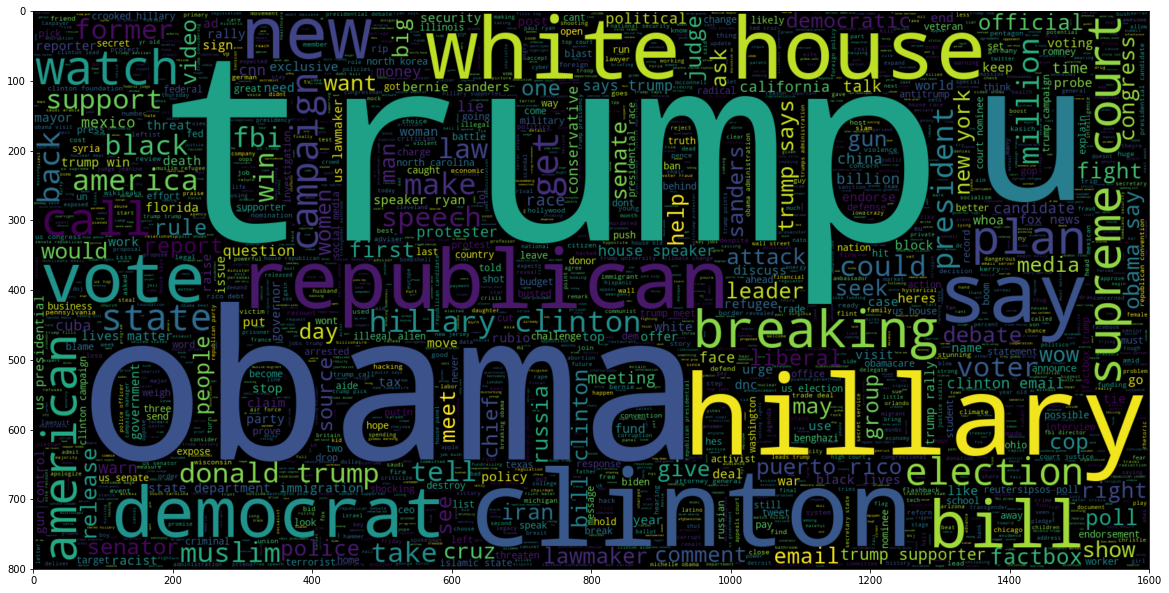

In [17]:
# Wordcloud of the titles of all news
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(news.title))
plt.imshow(wc , interpolation = 'bilinear')

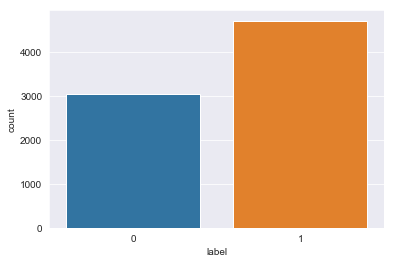

In [18]:

sns.set_style("darkgrid")
sns.countplot(news.label)

In [19]:
# Choose the title and text columns and split the data
X = news[['title', 'text']]
Y = news[['label']]
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True)

In [20]:
# Split the data as two sources: title and text 
x_train_title = x_train['title']
x_train_text = x_train['text']
x_test_title = x_test['title']
x_test_text = x_test['text']

y_train = y_train['label']
y_test = y_test['label']

# Part 1. Prediction based on Title

# Model1: Naive Bayes Model with TF-IDF inputs

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

In [22]:
model1_title = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_title.fit(x_train_title, y_train)
pred1_title = model1_title.predict(x_test_title)
f1_model1_title = f1_score(y_test, pred1_title, average = 'macro')

print('F1 score of model1_title:', f1_model1_title)

F1 score of model1_title: 0.9281289373295099


Text(28.6, 0.5, 'predicted label')

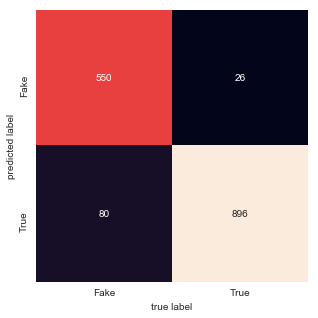

In [23]:
# plot the confusion matrix
mat = confusion_matrix(y_test, pred1_title)
label_name = ['Fake', 'True']
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=label_name, yticklabels=label_name)
plt.xlabel('true label')
plt.ylabel('predicted label')


# Model 2: Single Layer Neural Network Model with TF-IDF inputs

In [30]:
from sklearn.neural_network import MLPClassifier

model2_title = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50, ),random_state=1, verbose = True))
model2_title.fit(x_train_title, y_train)

Iteration 1, loss = 0.67931797
Iteration 2, loss = 0.58607968
Iteration 3, loss = 0.45919279
Iteration 4, loss = 0.33990822
Iteration 5, loss = 0.25078905
Iteration 6, loss = 0.18947957
Iteration 7, loss = 0.14758040
Iteration 8, loss = 0.11841614
Iteration 9, loss = 0.09669657
Iteration 10, loss = 0.08061329
Iteration 11, loss = 0.06804653
Iteration 12, loss = 0.05814917
Iteration 13, loss = 0.05024183
Iteration 14, loss = 0.04372418
Iteration 15, loss = 0.03837055
Iteration 16, loss = 0.03390911
Iteration 17, loss = 0.03015030
Iteration 18, loss = 0.02696851
Iteration 19, loss = 0.02423972
Iteration 20, loss = 0.02190843
Iteration 21, loss = 0.01992083
Iteration 22, loss = 0.01814972
Iteration 23, loss = 0.01662708
Iteration 24, loss = 0.01528897
Iteration 25, loss = 0.01409501
Iteration 26, loss = 0.01302000
Iteration 27, loss = 0.01207480
Iteration 28, loss = 0.01121923
Iteration 29, loss = 0.01049916
Iteration 30, loss = 0.00979514
Iteration 31, loss = 0.00917126
Iteration 32, los

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...e=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False))])

In [33]:
pred2_title = model2_title.predict(x_test_title)
f1_model2_title = f1_score(y_test, pred2_title, average = 'macro')
print('F1 score of model2_title:', f1_model2_title)

F1 score of model2_title: 0.9431500606551619


# Model 3: Multi Layer Neural Network Model with TF-IDF inputs

In [37]:
model3_title = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(200,200,200,200, ),random_state=1, verbose = True))
model3_title.fit(x_train_title, y_train)

Iteration 1, loss = 0.58296919
Iteration 2, loss = 0.10330109
Iteration 3, loss = 0.01375077
Iteration 4, loss = 0.00168248
Iteration 5, loss = 0.00049345
Iteration 6, loss = 0.00030998
Iteration 7, loss = 0.00025794
Iteration 8, loss = 0.00023576
Iteration 9, loss = 0.00022034
Iteration 10, loss = 0.00020969
Iteration 11, loss = 0.00020404
Iteration 12, loss = 0.00020012
Iteration 13, loss = 0.00019695
Iteration 14, loss = 0.00019417
Iteration 15, loss = 0.00019171
Iteration 16, loss = 0.00018949
Iteration 17, loss = 0.00018740
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [38]:
pred3_title = model3_title.predict(x_test_title)
f1_model3_title = f1_score(y_test, pred3_title, average = 'macro')
print('F1 score of model3_title:', f1_model3_title)

F1 score of model3_title: 0.9406242007277541


# Model 4: Single Layer Neural Network Model with embedding inputs

In [31]:
# Convert the raw embedding file to a dictionary.
f = open('glove.6B.100d.txt', 'r', encoding='UTF-8')
gloveModel = {}
for line in f:
    splitLines = line.split()
    word = splitLines[0]
    wordEmbedding = np.asarray(splitLines[1:])
    gloveModel[word] = wordEmbedding

In [32]:
# Convert the vector format of embedding dictionary, from string to float
WordVector ={key:np.array([float(number) for number in item], dtype=np.float32) for key, item in gloveModel.items()}

In [33]:
# get the embedding of each file
def calc_doc_embedding(doc, embeddings, embed_size, OOV_embed):
    doc_list = doc.lower().split()
    doc_embed = np.zeros(embed_size)
    length = 0
    for word in doc_list:
        if word in embeddings:
            doc_embed = doc_embed + embeddings[word]
            length += 1
        else:
            if word in OOV_embed:
                doc_embed = doc_embed + OOV_embed[word]
                length += 1
            else:
                OOV_embed[word] = np.random.rand(embed_size)
                doc_embed = doc_embed + OOV_embed[word]
                length += 1
    doc_embed = doc_embed / length
    return doc_embed

x_train_title_embed = np.vstack([calc_doc_embedding(doc, WordVector, 100, {}) for doc in x_train_title])
x_test_title_embed = np.vstack([calc_doc_embedding(doc, WordVector, 100, {}) for doc in x_test_title])

In [34]:
# Fit the model
model4_title = MLPClassifier(hidden_layer_sizes=(50), random_state = 1, max_iter=500,verbose=True)
model4_title.fit(x_train_title_embed, y_train)

Iteration 1, loss = 0.57148566
Iteration 2, loss = 0.40693253
Iteration 3, loss = 0.34758507
Iteration 4, loss = 0.32345114
Iteration 5, loss = 0.30876106
Iteration 6, loss = 0.29846880
Iteration 7, loss = 0.29182163
Iteration 8, loss = 0.28541255
Iteration 9, loss = 0.27865389
Iteration 10, loss = 0.27630092
Iteration 11, loss = 0.27122528
Iteration 12, loss = 0.26997586
Iteration 13, loss = 0.26612284
Iteration 14, loss = 0.26456145
Iteration 15, loss = 0.26522210
Iteration 16, loss = 0.26138027
Iteration 17, loss = 0.25911931
Iteration 18, loss = 0.26284989
Iteration 19, loss = 0.26181786
Iteration 20, loss = 0.25821570
Iteration 21, loss = 0.25375596
Iteration 22, loss = 0.25241609
Iteration 23, loss = 0.25107111
Iteration 24, loss = 0.25032043
Iteration 25, loss = 0.24750774
Iteration 26, loss = 0.24628778
Iteration 27, loss = 0.24539499
Iteration 28, loss = 0.24547119
Iteration 29, loss = 0.24278446
Iteration 30, loss = 0.24214592
Iteration 31, loss = 0.23998573
Iteration 32, los

Iteration 253, loss = 0.06388440
Iteration 254, loss = 0.06239118
Iteration 255, loss = 0.06622837
Iteration 256, loss = 0.06424847
Iteration 257, loss = 0.06489643
Iteration 258, loss = 0.06116244
Iteration 259, loss = 0.05976427
Iteration 260, loss = 0.06186089
Iteration 261, loss = 0.05937892
Iteration 262, loss = 0.05927482
Iteration 263, loss = 0.05825706
Iteration 264, loss = 0.05768220
Iteration 265, loss = 0.05785463
Iteration 266, loss = 0.05730458
Iteration 267, loss = 0.05644968
Iteration 268, loss = 0.05623147
Iteration 269, loss = 0.05525661
Iteration 270, loss = 0.05899514
Iteration 271, loss = 0.05597699
Iteration 272, loss = 0.06629706
Iteration 273, loss = 0.09071207
Iteration 274, loss = 0.05949377
Iteration 275, loss = 0.05617809
Iteration 276, loss = 0.05402743
Iteration 277, loss = 0.05352515
Iteration 278, loss = 0.05239453
Iteration 279, loss = 0.05216652
Iteration 280, loss = 0.05246974
Iteration 281, loss = 0.05105167
Iteration 282, loss = 0.05092354
Iteration 

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [35]:
pred4_title = model4_title.predict(x_test_title_embed)
f1_model4_title = f1_score(y_test, pred4_title, average = 'macro')
print('F1 score of model4_title:', f1_model4_title)

F1 score of model4_title: 0.8992338657317231


# Model 5: Multi Layer Neural Network Model with embedding inputs

In [36]:
model5_title = MLPClassifier(hidden_layer_sizes=(200,200,200,200), random_state = 1, max_iter=500,verbose=True)
model5_title.fit(x_train_title_embed, y_train)

Iteration 1, loss = 0.42504001
Iteration 2, loss = 0.27825364
Iteration 3, loss = 0.24789366
Iteration 4, loss = 0.22459113
Iteration 5, loss = 0.19912042
Iteration 6, loss = 0.18003524
Iteration 7, loss = 0.15879639
Iteration 8, loss = 0.16442409
Iteration 9, loss = 0.13819197
Iteration 10, loss = 0.12422678
Iteration 11, loss = 0.09439970
Iteration 12, loss = 0.06861837
Iteration 13, loss = 0.05257262
Iteration 14, loss = 0.04199524
Iteration 15, loss = 0.02845828
Iteration 16, loss = 0.01909892
Iteration 17, loss = 0.01922431
Iteration 18, loss = 0.01501314
Iteration 19, loss = 0.01575052
Iteration 20, loss = 0.01184457
Iteration 21, loss = 0.00770512
Iteration 22, loss = 0.00799105
Iteration 23, loss = 0.01049626
Iteration 24, loss = 0.02178106
Iteration 25, loss = 0.07687103
Iteration 26, loss = 0.02127840
Iteration 27, loss = 0.00605466
Iteration 28, loss = 0.00190471
Iteration 29, loss = 0.00077580
Iteration 30, loss = 0.00056749
Iteration 31, loss = 0.00047995
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 200, 200, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [37]:
pred5_title = model5_title.predict(x_test_title_embed)
f1_model5_title = f1_score(y_test, pred5_title, average = 'macro')
print('F1 score of model5_title:', f1_model5_title)

F1 score of model5_title: 0.8991435685555585


# Model 6 : Simple RNN Model with Embeddings Input

In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Bidirectional

In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news['title'])
word_index = tokenizer.word_index

max_vocab = len(word_index) + 1
max_title_length = max([len(i.split()) for i in news['title']])


# tokenize the text into vectors 
x_train_title_rnn = tokenizer.texts_to_sequences(x_train_title)
x_test_title_rnn = tokenizer.texts_to_sequences(x_test_title)

#Apply padding so we have the same length for each article
x_train_title_rnn = pad_sequences(x_train_title_rnn, maxlen=max_title_length)
x_test_title_rnn = pad_sequences(x_test_title_rnn, maxlen=max_title_length)

In [47]:
# Generate the embedding matrix for model building
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [48]:
model6_title = Sequential(name = 'model6_title')
model6_title.add(Embedding(input_dim = max_vocab, output_dim = 100, input_length=max_title_length, weights=[embedding_matrix], trainable=False))
model6_title.add(SimpleRNN(32))
model6_title.add(Dense(1, activation = 'sigmoid'))
model6_title.summary()

Model: "model6_title"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1220700   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,224,989
Trainable params: 4,289
Non-trainable params: 1,220,700
_________________________________________________________________


In [49]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
model6_title.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model6_title_final = model6_title.fit(x_train_title_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32)
model6_title.evaluate(x_test_title_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 1s 4ms/step - loss: 0.4730 - accuracy: 0.7699 - val_loss: 0.3163 - val_accuracy: 0.8808
Epoch 2/10
175/175 [==============================] - 1s 3ms/step - loss: 0.2766 - accuracy: 0.8924 - val_loss: 0.2576 - val_accuracy: 0.8986
Epoch 3/10
175/175 [==============================] - 1s 3ms/step - loss: 0.2428 - accuracy: 0.9056 - val_loss: 0.2677 - val_accuracy: 0.8937
Epoch 4/10
175/175 [==============================] - 0s 3ms/step - loss: 0.2100 - accuracy: 0.9223 - val_loss: 0.2444 - val_accuracy: 0.9098
Epoch 5/10
175/175 [==============================] - 0s 3ms/step - loss: 0.2008 - accuracy: 0.9250 - val_loss: 0.2968 - val_accuracy: 0.8905
Epoch 6/10
175/175 [==============================] - 0s 3ms/step - loss: 0.1815 - accuracy: 0.9321 - val_loss: 0.2479 - val_accuracy: 0.8937
Epoch 7/10
175/175 [==============================] - 0s 3ms/step - loss: 0.1719 - accuracy: 0.9359 - val_loss: 0.2121 - val_accuracy: 0.9147
Epoch 

[0.2203238159418106, 0.9175257682800293]

In [50]:
# Define a function which can visualize the accuracy and loss with time
def model_plot(model):

    history_dict = model.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = model.epoch

    plt.figure(figsize=(12,9))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss', size=20)
    plt.xlabel('Epochs', size=20)
    plt.ylabel('Loss', size=20)
    plt.legend(prop={'size': 20})
    plt.show()

    plt.figure(figsize=(12,9))
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy', size=20)
    plt.xlabel('Epochs', size=20)

    plt.ylabel('Accuracy', size=20)
    plt.legend(prop={'size': 20})
    plt.ylim((0.5,1))
    plt.show()

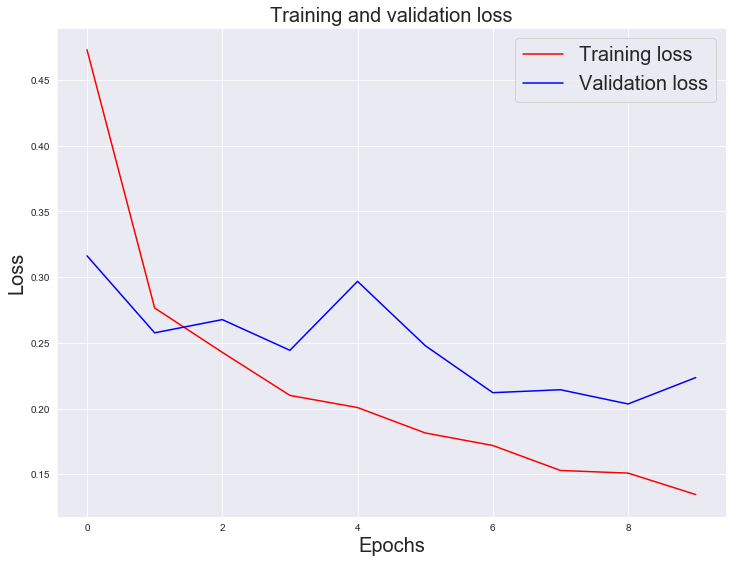

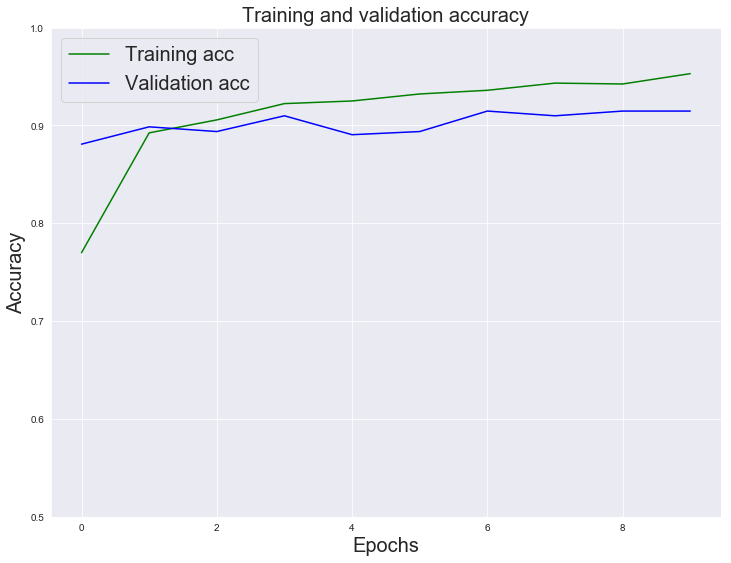

In [51]:
model_plot(model6_title_final)

In [52]:
# Define a function which can measure the macro_F1 score of RNN models
def rnn_f1(model, x_test_rnn):
    pred_prob = model.predict(x_test_rnn)
    pred = []
    
    for i in pred_prob:
        if i >= 0.5:
            pred.append(1)
        else:
            pred.append(0)
            
    f1_macro = f1_score(y_test, pred, average = 'macro')
    
    return f1_macro

In [53]:
print('F1 score of model6_title: ', rnn_f1(model6_title, x_test_title_rnn))

F1 score of model6_title:  0.9151818422468341


In [62]:
# Model 7: Sophisticated RNN Model with Embedding Inputs
model7_title = Sequential(name = 'model7_title')
model7_title.add(Embedding(input_dim = max_vocab, output_dim = 100, input_length=max_title_length, weights=[embedding_matrix], trainable=False))
model7_title.add(Bidirectional(LSTM(64, dropout = 0.2, return_sequences=True)))
model7_title.add(Bidirectional(LSTM(16, return_sequences=False)))
model7_title.add(Dense(32, activation = 'relu'))
model7_title.add(Dropout(rate=0.5))
model7_title.add(Dense(1, activation = 'sigmoid'))
model7_title.summary()

Model: "model7_title"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           1220700   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 30, 128)           84480     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,324,829
Trainable params: 104,129
Non-trainable params: 1,220,700
______________________________________

In [63]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
model7_title.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model7_title_final = model7_title.fit(x_train_title_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32,callbacks=[early_stop])
model7_title.evaluate(x_test_title_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 5s 27ms/step - loss: 0.3724 - accuracy: 0.8460 - val_loss: 0.2194 - val_accuracy: 0.9163
Epoch 2/10
175/175 [==============================] - 4s 20ms/step - loss: 0.2263 - accuracy: 0.9133 - val_loss: 0.1956 - val_accuracy: 0.9195
Epoch 3/10
175/175 [==============================] - 4s 20ms/step - loss: 0.1969 - accuracy: 0.9260 - val_loss: 0.1800 - val_accuracy: 0.9243
Epoch 4/10
175/175 [==============================] - 4s 20ms/step - loss: 0.1669 - accuracy: 0.9400 - val_loss: 0.1671 - val_accuracy: 0.9340
Epoch 5/10
175/175 [==============================] - 4s 20ms/step - loss: 0.1573 - accuracy: 0.9438 - val_loss: 0.1556 - val_accuracy: 0.9388
Epoch 6/10
175/175 [==============================] - 4s 20ms/step - loss: 0.1417 - accuracy: 0.9529 - val_loss: 0.1748 - val_accuracy: 0.9340
Epoch 7/10
175/175 [==============================] - 4s 20ms/step - loss: 0.1235 - accuracy: 0.9558 - val_loss: 0.1456 - val_accuracy: 0.9420

[0.13748879730701447, 0.9536082744598389]

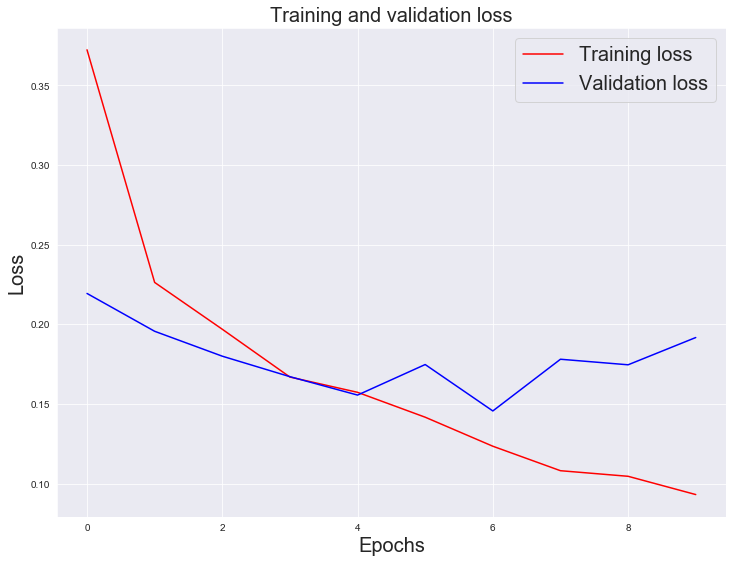

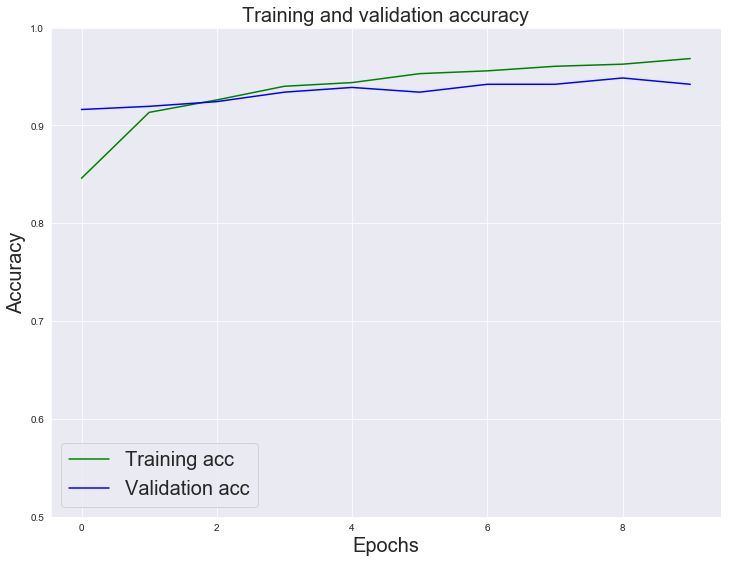

In [64]:
model_plot(model7_title_final)

In [65]:
print('F1 score of model7_title: ', rnn_f1(model7_title, x_test_title_rnn))

F1 score of model7_title:  0.951680443344386


# 2. Prediction based on Text

In [57]:
# Model 1: Naive Bayes Model with TF-IDF inputs
model1_text = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_text.fit(x_train_text, y_train)
pred1_text = model1_text.predict(x_test_text)
f1_macro = f1_score(y_test, pred1_text, average = 'macro')
f1_micro = f1_score(y_test, pred1_text, average = 'micro')

print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.6561700963251216
microaveraged F1:  0.7287371134020618


In [58]:
# Model 2: Single Layer Neural Network Model with TF-IDF inputs
model2_text = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50, ), random_state=1, verbose = True))
model2_text.fit(x_train_text, y_train)
pred2_text = model2_text.predict(x_test_text)
f1_macro = f1_score(y_test, pred2_text, average = 'macro')
f1_micro = f1_score(y_test, pred2_text, average = 'micro')

Iteration 1, loss = 0.60506918
Iteration 2, loss = 0.40863560
Iteration 3, loss = 0.25178339
Iteration 4, loss = 0.15828300
Iteration 5, loss = 0.10529325
Iteration 6, loss = 0.07376747
Iteration 7, loss = 0.05396829
Iteration 8, loss = 0.04103129
Iteration 9, loss = 0.03210281
Iteration 10, loss = 0.02582662
Iteration 11, loss = 0.02131203
Iteration 12, loss = 0.01790139
Iteration 13, loss = 0.01529733
Iteration 14, loss = 0.01324577
Iteration 15, loss = 0.01164221
Iteration 16, loss = 0.01032906
Iteration 17, loss = 0.00924273
Iteration 18, loss = 0.00835967
Iteration 19, loss = 0.00761715
Iteration 20, loss = 0.00700036
Iteration 21, loss = 0.00647684
Iteration 22, loss = 0.00601770
Iteration 23, loss = 0.00562620
Iteration 24, loss = 0.00528585
Iteration 25, loss = 0.00498615
Iteration 26, loss = 0.00471851
Iteration 27, loss = 0.00447823
Iteration 28, loss = 0.00426447
Iteration 29, loss = 0.00407562
Iteration 30, loss = 0.00390248
Iteration 31, loss = 0.00374778
Iteration 32, los

In [59]:
print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.9738057371355868
microaveraged F1:  0.9748711340206185


In [61]:
# Model 3: Single Layer Neural Network Model with TF-IDF inputs
model3_text = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(100,100,100, ), random_state=1, verbose = True))
model3_text.fit(x_train_text, y_train)
pred3_text = model3_text.predict(x_test_text)
f1_macro = f1_score(y_test, pred3_text, average = 'macro')
f1_micro = f1_score(y_test, pred3_text, average = 'micro')

Iteration 1, loss = 0.54850161
Iteration 2, loss = 0.12517372
Iteration 3, loss = 0.00760103
Iteration 4, loss = 0.00131876
Iteration 5, loss = 0.00071834
Iteration 6, loss = 0.00053065
Iteration 7, loss = 0.00043286
Iteration 8, loss = 0.00036933
Iteration 9, loss = 0.00032045
Iteration 10, loss = 0.00028963
Iteration 11, loss = 0.00027108
Iteration 12, loss = 0.00025796
Iteration 13, loss = 0.00024654
Iteration 14, loss = 0.00022971
Iteration 15, loss = 0.00021676
Iteration 16, loss = 0.00020943
Iteration 17, loss = 0.00020403
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [62]:
print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.9778829449159404
microaveraged F1:  0.9787371134020618


In [65]:
# Model 4 : Single Layer Neural Network Model with embeddings inputs

x_train_text_embed = np.vstack([calc_doc_embedding(doc, wv, 100, {}) for doc in x_train_text])
x_test_text_embed = np.vstack([calc_doc_embedding(doc, wv, 100, {}) for doc in x_test_text])

model4_text = MLPClassifier(hidden_layer_sizes=(50), max_iter=500,random_state=1,verbose=True)
model4_text.fit(x_train_text_embed, y_train)
pred4_text = model4_text.predict(x_test_text_embed)
f1_macro = f1_score(y_test, pred4_text, average = 'macro')
f1_micro = f1_score(y_test, pred4_text, average = 'micro')

Iteration 1, loss = 0.60287858
Iteration 2, loss = 0.47486580
Iteration 3, loss = 0.40445937
Iteration 4, loss = 0.37209889
Iteration 5, loss = 0.34682131
Iteration 6, loss = 0.33163748
Iteration 7, loss = 0.31586797
Iteration 8, loss = 0.30418630
Iteration 9, loss = 0.29337923
Iteration 10, loss = 0.28381220
Iteration 11, loss = 0.27738200
Iteration 12, loss = 0.26888217
Iteration 13, loss = 0.26187926
Iteration 14, loss = 0.25729842
Iteration 15, loss = 0.25526321
Iteration 16, loss = 0.25098971
Iteration 17, loss = 0.24312569
Iteration 18, loss = 0.24187388
Iteration 19, loss = 0.23540219
Iteration 20, loss = 0.23229816
Iteration 21, loss = 0.23040218
Iteration 22, loss = 0.22662139
Iteration 23, loss = 0.22586214
Iteration 24, loss = 0.22071941
Iteration 25, loss = 0.21826079
Iteration 26, loss = 0.21620742
Iteration 27, loss = 0.21442522
Iteration 28, loss = 0.21749700
Iteration 29, loss = 0.20946025
Iteration 30, loss = 0.20982694
Iteration 31, loss = 0.20681046
Iteration 32, los

Iteration 257, loss = 0.11003750
Iteration 258, loss = 0.10190116
Iteration 259, loss = 0.10148962
Iteration 260, loss = 0.10120571
Iteration 261, loss = 0.10509880
Iteration 262, loss = 0.10129696
Iteration 263, loss = 0.10165329
Iteration 264, loss = 0.09990092
Iteration 265, loss = 0.10060662
Iteration 266, loss = 0.10227215
Iteration 267, loss = 0.10406139
Iteration 268, loss = 0.10079291
Iteration 269, loss = 0.10258378
Iteration 270, loss = 0.10176757
Iteration 271, loss = 0.10254394
Iteration 272, loss = 0.11241417
Iteration 273, loss = 0.10086639
Iteration 274, loss = 0.10160443
Iteration 275, loss = 0.10855114
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [66]:
print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.937210343284096
microaveraged F1:  0.9394329896907216


In [67]:
# Model 5 : Multi-Layer Neural Network Model with embeddings inputs
model5_text = MLPClassifier(hidden_layer_sizes=(200,200,200,200),random_state=1, max_iter=500,verbose=True)
model5_text.fit(x_train_text_embed, y_train)
pred5_text = model5_text.predict(x_test_text_embed)
f1_macro = f1_score(y_test, pred5_text, average = 'macro')
f1_micro = f1_score(y_test, pred5_text, average = 'micro')

Iteration 1, loss = 0.46172587
Iteration 2, loss = 0.28646514
Iteration 3, loss = 0.25335552
Iteration 4, loss = 0.22376946
Iteration 5, loss = 0.20733002
Iteration 6, loss = 0.19814513
Iteration 7, loss = 0.18070012
Iteration 8, loss = 0.19809335
Iteration 9, loss = 0.16794120
Iteration 10, loss = 0.21527383
Iteration 11, loss = 0.15643323
Iteration 12, loss = 0.14964068
Iteration 13, loss = 0.17546337
Iteration 14, loss = 0.14214305
Iteration 15, loss = 0.11898792
Iteration 16, loss = 0.11243933
Iteration 17, loss = 0.10664286
Iteration 18, loss = 0.11541407
Iteration 19, loss = 0.09702839
Iteration 20, loss = 0.20608504
Iteration 21, loss = 0.10589429
Iteration 22, loss = 0.13272417
Iteration 23, loss = 0.09842930
Iteration 24, loss = 0.08260531
Iteration 25, loss = 0.09698901
Iteration 26, loss = 0.07943303
Iteration 27, loss = 0.06979729
Iteration 28, loss = 0.18406542
Iteration 29, loss = 0.08412536
Iteration 30, loss = 0.08793381
Iteration 31, loss = 0.10783360
Iteration 32, los

In [68]:
print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.9256847347251485
microaveraged F1:  0.9278350515463918


In [214]:
#Model 6 : RNN with embeddings input


#Convert text to vectors, our classifier only takes numerical data.
x_train_text_rnn = normalize(x_train_text)
x_test_text_rnn = normalize(x_test_text)

In [215]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train_text_rnn)

# tokenize the text into vectors 
x_train_text_rnn = tokenizer.texts_to_sequences(x_train_text_rnn)
x_test_text_rnn = tokenizer.texts_to_sequences(x_test_text_rnn)

#Apply padding so we have the same length for each article
x_train_text_rnn = tf.keras.preprocessing.sequence.pad_sequences(x_train_text_rnn, padding='post', maxlen=256)
x_test_text_rnn = tf.keras.preprocessing.sequence.pad_sequences(x_test_text_rnn, padding='post', maxlen=256)


In [217]:
# early stop when the validation loss no longer improve.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model6.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model6_text = model6.fit(x_train_text_rnn, y_train, epochs=5,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
187/187 [==============================] - 38s 204ms/step - loss: 0.1485 - accuracy: 0.9540 - val_loss: 0.2203 - val_accuracy: 0.9163
Epoch 2/10
187/187 [==============================] - 31s 164ms/step - loss: 0.1041 - accuracy: 0.9708 - val_loss: 0.2175 - val_accuracy: 0.9211
Epoch 3/10
187/187 [==============================] - 31s 165ms/step - loss: 0.0711 - accuracy: 0.9823 - val_loss: 0.2165 - val_accuracy: 0.9291
Epoch 4/10
187/187 [==============================] - 31s 166ms/step - loss: 0.0593 - accuracy: 0.9875 - val_loss: 0.2199 - val_accuracy: 0.9291
Epoch 5/10
187/187 [==============================] - 37s 195ms/step - loss: 0.0493 - accuracy: 0.9910 - val_loss: 0.2549 - val_accuracy: 0.9356


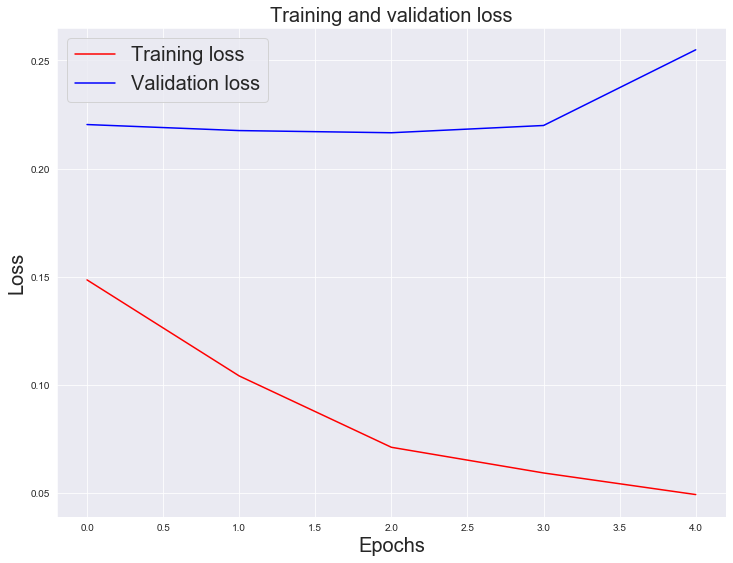

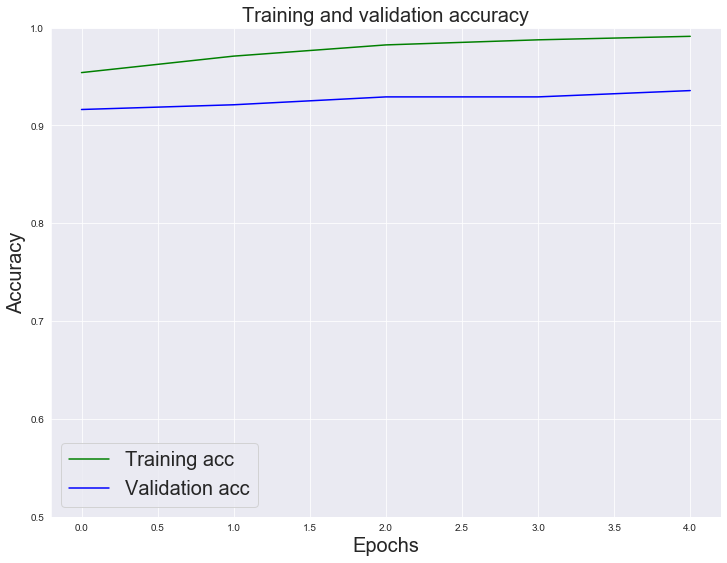

In [218]:
#Visualize our training over time
history_dict = model6_text.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = model6_text.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [219]:
#Evaluate the testing set
pred = model6.predict(x_test_text_rnn)
pred6_text = []

for i in pred:
    if i >= 0.5:
        pred6_text.append(1)
    else:
        pred6_text.append(0) 


f1_macro = f1_score(y_test, pred6_text, average = 'macro')
f1_micro = f1_score(y_test, pred6_text, average = 'micro')

print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.9040062145785674
microaveraged F1:  0.907860824742268
